In [ ]:
#Numpy, pandas
import numpy as np
import pandas as pd
#Date manipulation
import datetime as dt
#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
#Other libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('weatherHistory.csv')
df.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
df.shape

(96453, 12)

In [ ]:
# Drop duplicate values
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

df.fillna(method='ffill', inplace=True)  # Forward fill
df.dropna(inplace=True)  # Drop rows with missing values

#Change Humidity
df = df[(df['Humidity']>0.2) & (df['Humidity']<1)]
print('Shape: ',df.shape)
df.describe()

Shape:  (93373, 12)


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,93373.000000,93373.000000,93373.000000,93373.000000,93373.000000,93373.000000,93373.0,93373.000000
mean,12.137481,11.072184,0.727731,10.906694,187.895987,10.564589,0.0,1003.412416
std,9.518967,10.678056,0.191389,6.933869,107.414615,4.024806,0.0,116.088832
min,-21.822222,-27.716667,0.210000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.955556,2.633333,0.600000,5.973100,117.000000,9.611700,0.0,1011.930000
50%,12.177778,12.177778,0.780000,10.126900,180.000000,10.223500,0.0,1016.420000
75%,18.894444,18.894444,0.890000,14.184100,290.000000,14.908600,0.0,1020.990000
max,38.866667,39.344444,0.990000,63.852600,359.000000,16.100000,0.0,1046.380000


In [ ]:
#New categorical variable:
def cloud_categorizer(row):
   row = str(row).lower()
   category = ""
   if "foggy" in row:
       category = 5
   elif "overcast" in row:
       category = 4
   elif "mostly cloudy" in row:
       category = 3
   elif "partly cloudy" in row:
       category = 2
   elif "clear" in row:
       category = 1
   else:
       category = 0
   return category

df["cloud (summary)"] = df.apply (lambda row:cloud_categorizer(row["Summary"]) , axis = 1)

<Axes: >

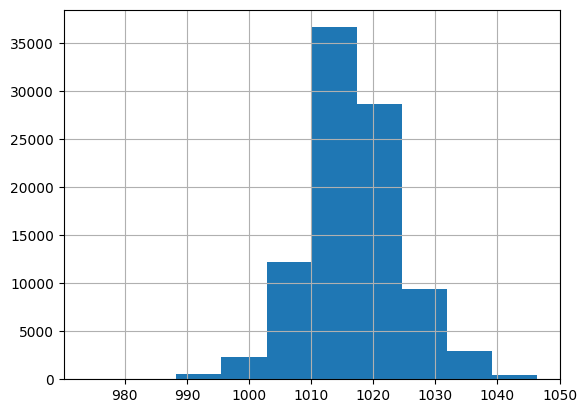

In [ ]:
pressure_median = df['Pressure (millibars)'].median()

def pressure(x):
      if x==0:
          return x + pressure_median
      else:
          return x

df["Pressure (millibars)"] = df.apply(lambda row:pressure(row["Pressure (millibars)"]) , axis = 1)
df['Pressure (millibars)'].hist()

<ipython-input-117-7052af584c81>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


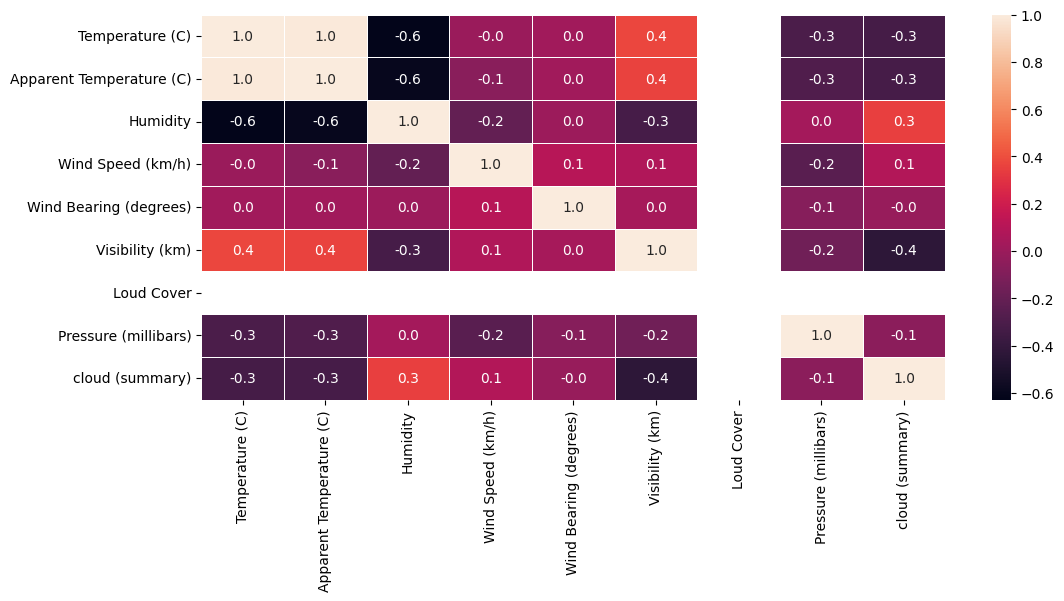

In [ ]:
f,ax = plt.subplots(figsize=(12, 5))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [ ]:
# Another preprocess the data
df['Precip Type'] = df['Precip Type'].fillna('none')
encoder = LabelEncoder()
df['Rain'] = encoder.fit_transform(df['Precip Type'])


In [ ]:
# Selecting features and target
features = df[['Humidity', 'Pressure (millibars)']]
target = df['Rain']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the neural network
model = Sequential([
    Dense(64, input_shape=(2,), activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with an adjustable learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with updated data
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_split=0.2)  # Increased epochs

# Evaluate the model with normalized test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/150
2101/2101 [==============================] - 6s 2ms/step - loss: 0.3141 - accuracy: 0.8918 - val_loss: 0.2712 - val_accuracy: 0.8993
Epoch 2/150
2101/2101 [==============================] - 6s 3ms/step - loss: 0.2699 - accuracy: 0.8998 - val_loss: 0.2665 - val_accuracy: 0.9005
Epoch 3/150
2101/2101 [==============================] - 4s 2ms/step - loss: 0.2671 - accuracy: 0.9004 - val_loss: 0.2652 - val_accuracy: 0.9016
Epoch 4/150
2101/2101 [==============================] - 5s 2ms/step - loss: 0.2658 - accuracy: 0.9005 - val_loss: 0.2648 - val_accuracy: 0.9018
Epoch 5/150
2101/2101 [==============================] - 6s 3ms/step - loss: 0.2648 - accuracy: 0.9007 - val_loss: 0.2646 - val_accuracy: 0.9025
Epoch 6/150
2101/2101 [==============================] - 5s 2ms/step - loss: 0.2647 - accuracy: 0.9004 - val_loss: 0.2645 - val_accuracy: 0.9021
Epoch 7/150
2101/2101 [==============================] - 6s 3ms/step - loss: 0.2639 - accuracy: 0.9006 - val_loss: 0.2644 - val_ac

In [ ]:
def predict_rain(humidity, pressure):
    # Normalize the input features using the same scaler used during training
    input_features = scaler.transform([[humidity, pressure]])

    # Make a prediction
    prediction = model.predict(input_features)

    # Convert prediction to a human-readable form
    if prediction[0][0] > 0.5:
        return "It's likely to rain!"
    else:
        return "It's unlikely to rain!"

# Example usage
humidity_input = float(input("Enter Humidity percentage (e.g., 0.85 for 85%): "))
pressure_input = float(input("Enter Air Pressure in millibars (e.g., 1015.3): "))
print(predict_rain(humidity_input, pressure_input))

Enter Humidity percentage (e.g., 0.85 for 85%): 0.68
Enter Air Pressure in millibars (e.g., 1015.3): 1018.17
1/1 [==============================] - 0s 21ms/step
It's unlikely to rain!


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,cloud (summary),Rain
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2,0
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2,0
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,3,0
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2,0
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96424,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.,2,0
96425,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.,2,0
96426,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.,2,0
96427,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.,2,0


In [ ]:
# Selecting features and target
features = df[['Humidity', 'Pressure (millibars)']]
target = df['cloud (summary)']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the neural network
model = Sequential([
    Dense(64, input_shape=(2,), activation='relu'),  # Increased number of neurons
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with an adjustable learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with updated data
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=32, validation_split=0.2)  # Increased epochs

# Evaluate the model with normalized test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/150
2101/2101 [==============================] - 6s 2ms/step - loss: -310417280522927262604288065536.0000 - accuracy: 0.1146 - val_loss: -23209301219894421450694783401984.0000 - val_accuracy: 0.1148
Epoch 2/150
2101/2101 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.1147 - val_loss: nan - val_accuracy: 0.1148
Epoch 3/150
2101/2101 [==============================] - 5s 2ms/step - loss: nan - accuracy: 0.0528 - val_loss: nan - val_accuracy: 0.0026
Epoch 4/150
2101/2101 [==============================] - 5s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0026
Epoch 5/150
2101/2101 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0026
Epoch 6/150
2101/2101 [==============================] - 5s 2ms/step - loss: nan - accuracy: 0.0020 - val_loss: nan - val_accuracy: 0.0026
Epoch 7/150
2101/2101 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.002